# Get Coordinates #

This script is used to get all the coordinates of each pose's keypoints and saves it into a CSV file.

### Import dependencies ###

In [1]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
import mediapipe as mp
from typing import List, Optional, Tuple, Union, Mapping
from mediapipe.framework.formats import landmark_pb2
from dataclasses import dataclass

### Resize image function ###

In [2]:
DESIRED_HEIGHT = 800
DESIRED_WIDTH = 800

def resize(image):
    h, w = image.shape[:2]
    if h < w:
        return cv2.resize(image, (DESIRED_WIDTH, math.floor(h/(w/DESIRED_WIDTH))))
    else:
        return cv2.resize(image, (math.floor(w/(h/DESIRED_HEIGHT)), DESIRED_HEIGHT))

### Import images ###

In [3]:
images = []

image1 = resize(cv2.imread("reference_pose/p_hidari_chudan_oi_zuki.png"))

images.append(image1)

### Run mediapipe ###

In [4]:
mp_pose = mp.solutions.pose
mp_drawing_styles = mp.solutions.drawing_styles

with mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.7, model_complexity=2) as pose:
    for image in images:
        results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        image_height, image_width, _ = image.shape
        if not results.pose_landmarks:
            continue
        
        print(
            f'Landmark Coordinates: ('
            f'{results.pose_landmarks})'
        )

        #TODO: CHANGE PRINT TO TRANSFER TO CSV FILE

Landmark Coordinates: (landmark {
  x: 0.49249735474586487
  y: 0.3149045705795288
  z: -0.13016489148139954
  visibility: 0.9999983310699463
}
landmark {
  x: 0.49565768241882324
  y: 0.3050420880317688
  z: -0.1255389153957367
  visibility: 0.9999978542327881
}
landmark {
  x: 0.49732714891433716
  y: 0.30476438999176025
  z: -0.1256789267063141
  visibility: 0.999997615814209
}
landmark {
  x: 0.4994075298309326
  y: 0.3045043647289276
  z: -0.12563346326351166
  visibility: 0.9999982118606567
}
landmark {
  x: 0.4898930788040161
  y: 0.30513718724250793
  z: -0.1210000291466713
  visibility: 0.9999982118606567
}
landmark {
  x: 0.4877280294895172
  y: 0.3049751818180084
  z: -0.12109944969415665
  visibility: 0.9999982118606567
}
landmark {
  x: 0.48603305220603943
  y: 0.3046990633010864
  z: -0.1211240291595459
  visibility: 0.9999980926513672
}
landmark {
  x: 0.5020735859870911
  y: 0.305534303188324
  z: -0.08179881423711777
  visibility: 0.9999984502792358
}
landmark {
  x: 0

### Mediapipe Constants and Tools ###

In [5]:
WHITE_COLOR = (224, 224, 224)
BLACK_COLOR = (0, 0, 0)
RED_COLOR = (0, 0, 255)

_PRESENCE_THRESHOLD = 0.05
_VISIBILITY_THRESHOLD = 0.05
_BGR_CHANNELS = 3

@dataclass
class DrawingSpec:
    color: Tuple[int, int, int] = WHITE_COLOR
    thickness: int = 2
    circle_radius: int = 2

def _normalize_color(color):
    return tuple(v / 255. for v in color)

def _normalized_to_pixel_coordinates(
        normalized_x: float, normalized_y: float, image_width: int,
        image_height: int) -> Union[None, Tuple[int, int]]:
    """Converts normalized value pair to pixel coordinates."""

    # Checks if the float value is between 0 and 1.
    def is_valid_normalized_value(value: float) -> bool:
        return (value > 0 or math.isclose(0, value)) and (value < 1 or math.isclose(1, value))
        
    x_px = min(math.floor(normalized_x * image_width), image_width - 1)
    y_px = min(math.floor(normalized_y * image_height), image_height - 1)
    return x_px, y_px

### Draw landmarks ###

In [7]:
def draw_landmarks(
    image: np.ndarray,
    landmark_list: landmark_pb2.NormalizedLandmarkList,
    connections: Optional[List[Tuple[int, int]]] = None,
    landmark_drawing_spec: Union[DrawingSpec,
                                 Mapping[int, DrawingSpec]] = DrawingSpec(
                                     color=RED_COLOR),
    connection_drawing_spec: Union[DrawingSpec,
                                   Mapping[Tuple[int, int],
                                           DrawingSpec]] = DrawingSpec()):
    """Draws the landmarks and the connections on the image.

    Args:
      image: A three channel BGR image represented as numpy ndarray.
      landmark_list: A normalized landmark list proto message to be annotated on
        the image.
      connections: A list of landmark index tuples that specifies how landmarks to
        be connected in the drawing.
      landmark_drawing_spec: Either a DrawingSpec object or a mapping from hand
        landmarks to the DrawingSpecs that specifies the landmarks' drawing
        settings such as color, line thickness, and circle radius. If this
        argument is explicitly set to None, no landmarks will be drawn.
      connection_drawing_spec: Either a DrawingSpec object or a mapping from hand
        connections to the DrawingSpecs that specifies the connections' drawing
        settings such as color and line thickness. If this argument is explicitly
        set to None, no landmark connections will be drawn.

    Raises:
      ValueError: If one of the followings:
        a) If the input image is not three channel BGR.
        b) If any connetions contain invalid landmark index.
    """
    if not landmark_list:
        return
    if image.shape[2] != _BGR_CHANNELS:
        raise ValueError('Input image must contain three channel bgr data.')
    image_rows, image_cols, _ = image.shape
    idx_to_coordinates = {}
    for idx, landmark in enumerate(landmark_list.landmark):
        if ((landmark.HasField('visibility') and
             landmark.visibility < _VISIBILITY_THRESHOLD) or
            (landmark.HasField('presence') and
             landmark.presence < _PRESENCE_THRESHOLD)):
            continue
        landmark_px = _normalized_to_pixel_coordinates(landmark.x, landmark.y,
                                                       image_cols, image_rows)
        if landmark_px:
            idx_to_coordinates[idx] = landmark_px
    if connections:
        num_landmarks = len(landmark_list.landmark)
        # Draws the connections if the start and end landmarks are both visible.
        for connection in connections:
            start_idx = connection[0]
            end_idx = connection[1]
            if not (0 <= start_idx < num_landmarks and 0 <= end_idx < num_landmarks):
                raise ValueError(f'Landmark index is out of range. Invalid connection '
                                 f'from landmark #{start_idx} to landmark #{end_idx}.')
            if start_idx in idx_to_coordinates and end_idx in idx_to_coordinates:
                drawing_spec = connection_drawing_spec[connection] if isinstance(
                    connection_drawing_spec, Mapping) else connection_drawing_spec
                cv2.line(image, idx_to_coordinates[start_idx],
                         idx_to_coordinates[end_idx], drawing_spec.color,
                         drawing_spec.thickness)
    # Draws landmark points after finishing the connection lines, which is
    # aesthetically better.
    if landmark_drawing_spec:
        for idx, landmark_px in idx_to_coordinates.items():
            drawing_spec = landmark_drawing_spec[idx] if isinstance(
                landmark_drawing_spec, Mapping) else landmark_drawing_spec
            # White circle border
            circle_border_radius = max(drawing_spec.circle_radius + 1,
                                       int(drawing_spec.circle_radius * 1.2))
            cv2.circle(image, landmark_px, circle_border_radius, WHITE_COLOR,
                       drawing_spec.thickness)
            # Fill color into the circle
            cv2.circle(image, landmark_px, drawing_spec.circle_radius,
                       drawing_spec.color, drawing_spec.thickness)

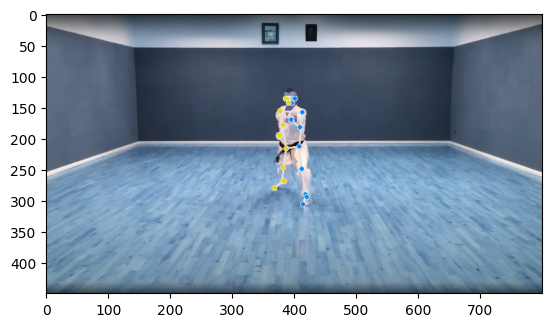

In [8]:
annotated_image = image.copy()
draw_landmarks(
    annotated_image,
    results.pose_landmarks,
    mp_pose.POSE_CONNECTIONS,
    landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
plt.imshow(annotated_image)

### Plot landmarks ###

In [9]:
def plot_landmarks(landmark_list: landmark_pb2.NormalizedLandmarkList,
                   connections: Optional[List[Tuple[int, int]]] = None,
                   landmark_drawing_spec: DrawingSpec = DrawingSpec(
                       color=RED_COLOR, thickness=5),
                   connection_drawing_spec: DrawingSpec = DrawingSpec(
                       color=BLACK_COLOR, thickness=5),
                   elevation: int = 10,
                   azimuth: int = 10):

    """Plot the landmarks and the connections in matplotlib 3d.

    Args:
      landmark_list: A normalized landmark list proto message to be plotted.
      connections: A list of landmark index tuples that specifies how landmarks to
        be connected.
      landmark_drawing_spec: A DrawingSpec object that specifies the landmarks'
        drawing settings such as color and line thickness.
      connection_drawing_spec: A DrawingSpec object that specifies the
        connections' drawing settings such as color and line thickness.
      elevation: The elevation from which to view the plot.
      azimuth: the azimuth angle to rotate the plot.

    Raises:
      ValueError: If any connection contains an invalid landmark index.
    """
    
    if not landmark_list:
        return
    plt.figure(figsize=(10, 10))
    ax = plt.axes(projection='3d')
    ax.view_init(elev=elevation, azim=azimuth)
    plotted_landmarks = {}
    for idx, landmark in enumerate(landmark_list.landmark):
        if ((landmark.HasField('visibility') and
             landmark.visibility < _VISIBILITY_THRESHOLD) or
            (landmark.HasField('presence') and
             landmark.presence < _PRESENCE_THRESHOLD)):
            continue
        ax.scatter3D(
            xs=[-landmark.z],
            ys=[landmark.x],
            zs=[-landmark.y],
            color=_normalize_color(landmark_drawing_spec.color[::-1]),
            linewidth=landmark_drawing_spec.thickness)
        plotted_landmarks[idx] = (-landmark.z, landmark.x, -landmark.y)
    if connections:
        num_landmarks = len(landmark_list.landmark)
        # Draws the connections if the start and end landmarks are both visible.
        for connection in connections:
            start_idx = connection[0]
            end_idx = connection[1]
            if not (0 <= start_idx < num_landmarks and 0 <= end_idx < num_landmarks):
                raise ValueError(f'Landmark index is out of range. Invalid connection '
                                 f'from landmark #{start_idx} to landmark #{end_idx}.')
            if start_idx in plotted_landmarks and end_idx in plotted_landmarks:
                landmark_pair = [
                    plotted_landmarks[start_idx], plotted_landmarks[end_idx]
                ]
                ax.plot3D(
                    xs=[landmark_pair[0][0], landmark_pair[1][0]],
                    ys=[landmark_pair[0][1], landmark_pair[1][1]],
                    zs=[landmark_pair[0][2], landmark_pair[1][2]],
                    color=_normalize_color(
                        connection_drawing_spec.color[::-1]),
                    linewidth=connection_drawing_spec.thickness)
    plt.show()

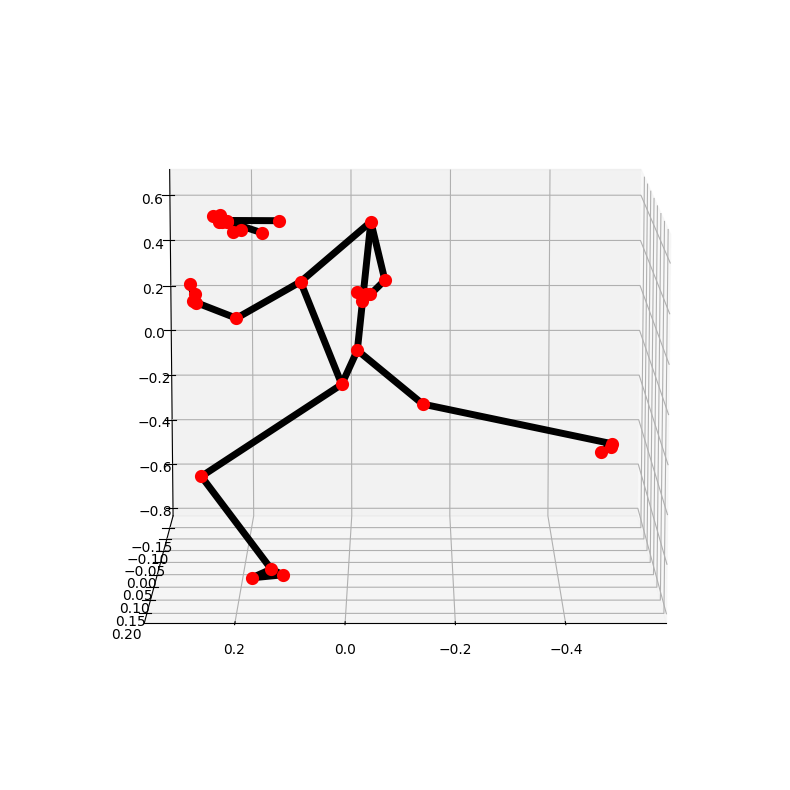

In [10]:
plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS, elevation=10, azimuth=90)